In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')


In [36]:
df = pd.read_csv('data/big_merged_sentiment_df.csv')
df = df[df['primary_call_reason'] != 'unknown']
# change post-flight to postflight
df['primary_call_reason'] = df['primary_call_reason'].apply(lambda x: 'postflight' if x == 'post-flight' else x)
df['primary_call_reason'] = df['primary_call_reason'].apply(lambda x: 'products&services' if x == 'productsandservices' else x)
df['primary_call_reason'] = df['primary_call_reason'].apply(lambda x: 'checkin' if x == 'check-in' else x)
df.dropna(inplace=True)


In [3]:
# Encode the target variable
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['primary_call_reason'])


In [4]:
# Split data into features and target
X = df['clean_transcript']
y = df['label']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [5]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

# Fit and transform the training data; transform the test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [6]:
# Initialize the model
nb_model = MultinomialNB()

# Train the model
nb_model.fit(X_train_tfidf, y_train)

# Predict on test data
y_pred_nb = nb_model.predict(X_test_tfidf)

# Evaluate the model
print("Naive Bayes Classifier Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:")
print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_))


Naive Bayes Classifier Performance:
Accuracy: 0.1988427143608627
Classification Report:
                    precision    recall  f1-score   support

           baggage       0.00      0.00      0.00       613
           booking       0.00      0.00      0.00       491
           checkin       0.00      0.00      0.00       420
          checkout       0.00      0.00      0.00       374
    communications       0.00      0.00      0.00       810
    digitalsupport       0.00      0.00      0.00       227
        disability       0.00      0.00      0.00        74
               etc       0.00      0.00      0.00       184
            irrops       0.20      0.96      0.33      2571
       mileageplus       0.00      0.00      0.00      1176
       othertopics       0.00      0.00      0.00       154
        postflight       0.00      0.00      0.00       845
 products&services       0.00      0.00      0.00       645
    schedulechange       0.00      0.00      0.00       153
           

100%|██████████| 33/33 [01:47<00:00,  3.25s/it]


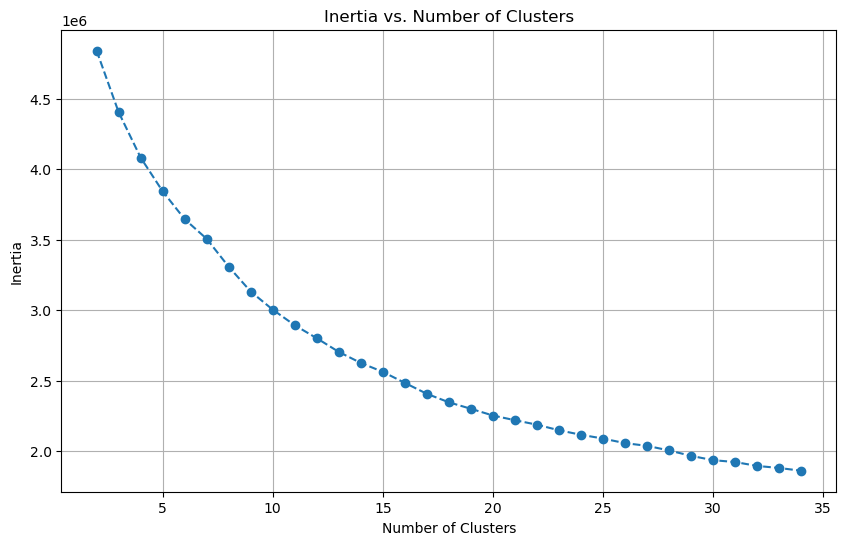

In [7]:
vectorizer_transcript = TfidfVectorizer(max_features=500, stop_words='english')
transcript_tfidf = vectorizer_transcript.fit_transform(df['clean_transcript'])

# Create DataFrame for TF-IDF features
transcript_tfidf_df = pd.DataFrame(transcript_tfidf.toarray(), columns=vectorizer_transcript.get_feature_names_out())

# Using separate OneHotEncoder instances for each categorical variable
enc_agent = OneHotEncoder()
agent_tone_ohe = enc_agent.fit_transform(df[['agent_tone']])
agent_tone_df = pd.DataFrame(agent_tone_ohe.toarray(), columns=enc_agent.get_feature_names_out())

enc_customer = OneHotEncoder()
customer_tone_ohe = enc_customer.fit_transform(df[['customer_tone']])
customer_tone_df = pd.DataFrame(customer_tone_ohe.toarray(), columns=enc_customer.get_feature_names_out())

# Reset indices if necessary (especially if data has been filtered or manipulated)
transcript_tfidf_df.reset_index(drop=True, inplace=True)
agent_tone_df.reset_index(drop=True, inplace=True)
customer_tone_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Combine features
features = pd.concat([transcript_tfidf_df, df[['handle_time', 's_time']]], axis=1)
features = pd.concat([features, agent_tone_df, customer_tone_df], axis=1)

# standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features = scaler.fit_transform(features)

# PCA
pca = PCA(n_components=20)
features = pca.fit_transform(features)

features = pd.DataFrame(features)

# K-means Clustering
inertia = []
for k in tqdm(range(2, 35)):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(features)  # Dropping NaNs as a precaution
    inertia.append(kmeans.inertia_)

# Plot the inertia values to identify the elbow point
plt.figure(figsize=(10,6))
plt.plot(range(2, 35), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs. Number of Clusters')
plt.grid()
plt.show()

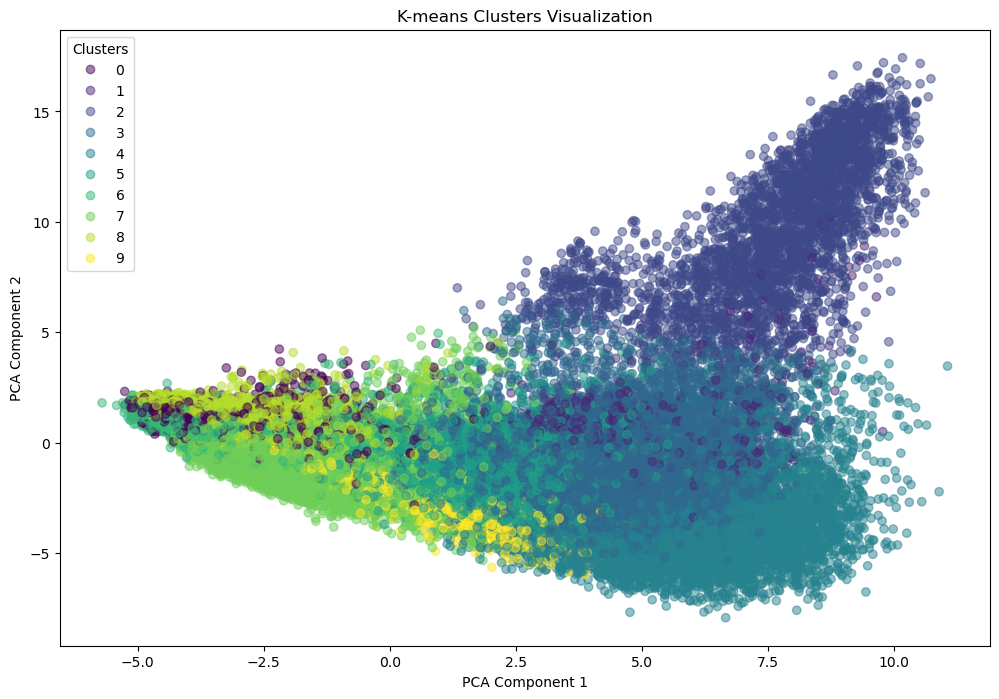

In [8]:
# Decide on the number of clusters (k) based on elbow plot
k = 10 # Select the k where the elbow occurs

# Apply K-means with the selected k
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(features)
df['cluster'] = kmeans.labels_

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Plot the clusters
plt.figure(figsize=(12,8))
scatter = plt.scatter(reduced_features[:,0], reduced_features[:,1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
plt.title('K-means Clusters Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [9]:
df['cluster'] = kmeans.labels_
for i in range(k):
    cluster_subset = df[df['cluster'] == i]
    print(f"Cluster {i}:")
    print("Top call reasons:")
    print(cluster_subset['primary_call_reason'].value_counts())
    
    # Get the intersection of indices
    common_indices = cluster_subset.index.intersection(transcript_tfidf_df.index)
    
    # Use only the common indices to sum up the TF-IDF scores
    top_words = transcript_tfidf_df.loc[common_indices, :].sum(axis=0).sort_values(ascending=False).head(10)
    print("Top words:")
    print(top_words)
    print("\n")

Cluster 0:
Top call reasons:
irrops                2285
voluntarychange       1556
seating                953
mileageplus            698
communications         564
postflight             444
baggage                395
booking                345
upgrade                343
products&services      316
checkout               261
checkin                260
voluntarycancel        220
travelerupdates        140
digitalsupport         137
othertopics            114
schedulechange         108
etc                     81
disability              39
unaccompaniedminor      12
Name: primary_call_reason, dtype: int64
Top words:
confirmation    1775.210658
number          1547.543355
need            1358.454349
change          1191.730049
reservation     1185.500766
flight          1077.472301
let              989.800864
pull             961.442612
problem          957.465636
smith            941.855852
dtype: float64


Cluster 1:
Top call reasons:
irrops                153
voluntarychange       127
se

The clusters are very inter-mixed. Hence, the results are not good.

In [37]:
# Determine the frequency of each call reason
call_reason_counts = df['primary_call_reason'].value_counts()

# Select the top N most frequent call reasons
N = 5
top_call_reasons = call_reason_counts.nlargest(N).index.tolist()
print(f"Top {N} most frequent call reasons:")
print(top_call_reasons)

Top 5 most frequent call reasons:
['irrops', 'voluntarychange', 'seating', 'mileageplus', 'postflight']


In [38]:
df_top = df[df['primary_call_reason'].isin(top_call_reasons)]
df_top.reset_index(drop=True, inplace=True)

# Check the distribution
print("Distribution of call reasons in the filtered dataset:")
print(df_top['primary_call_reason'].value_counts())


Distribution of call reasons in the filtered dataset:
irrops             13291
voluntarychange    10832
seating             6355
mileageplus         5838
postflight          4320
Name: primary_call_reason, dtype: int64


In [51]:
print(f"{len(df_top)/len(df)*100:.2f}%")

61.08%


In [39]:
from sklearn.utils import resample

# Separate majority and minority classes
dfs = []
min_class_count = df_top['primary_call_reason'].value_counts().min()

for reason in np.unique(df_top['primary_call_reason']):
    df_class = df_top[df_top['primary_call_reason'] == reason]
    df_class_downsampled = resample(df_class,
                                    replace=False,  # sample without replacement
                                    n_samples=min_class_count,  # to match minority class
                                    random_state=42)
    dfs.append(df_class_downsampled)

# Combine downsampled classes
df_balanced = pd.concat(dfs)
df_balanced.dropna(inplace=True)
# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Distribution after downsampling:")
print(df_balanced['primary_call_reason'].value_counts())


Distribution after downsampling:
voluntarychange    4320
postflight         4320
mileageplus        4320
seating            4320
irrops             4320
Name: primary_call_reason, dtype: int64


In [40]:
# Update label encoder with only the selected classes
label_encoder_filtered = LabelEncoder()
df_balanced['label'] = label_encoder_filtered.fit_transform(df_balanced['primary_call_reason'])

# Features and target
X_balanced = df_balanced['clean_transcript']
y_balanced = df_balanced['label']

# Split into training and test sets
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer_bal = TfidfVectorizer(ngram_range=(1,2))

# Fit and transform the training data; transform the test data
X_train_tfidf_bal = tfidf_vectorizer_bal.fit_transform(X_train_bal)
X_test_tfidf_bal = tfidf_vectorizer_bal.transform(X_test_bal)

In [41]:
# Initialize the model
nb_model_bal = MultinomialNB()

# Train the model
nb_model_bal.fit(X_train_tfidf_bal, y_train_bal)

# Predict on test data
y_pred_nb_bal = nb_model_bal.predict(X_test_tfidf_bal)

# Evaluate the model
print("Naive Bayes Classifier Performance on Filtered Dataset:")
print("Accuracy:", accuracy_score(y_test_bal, y_pred_nb_bal))
print("Classification Report:")
print(classification_report(y_test_bal, y_pred_nb_bal, target_names=label_encoder_filtered.classes_))

Naive Bayes Classifier Performance on Filtered Dataset:
Accuracy: 0.2912037037037037
Classification Report:
                 precision    recall  f1-score   support

         irrops       0.27      0.41      0.32       832
    mileageplus       0.29      0.28      0.28       876
     postflight       0.36      0.38      0.37       889
        seating       0.27      0.22      0.24       862
voluntarychange       0.27      0.16      0.20       861

       accuracy                           0.29      4320
      macro avg       0.29      0.29      0.28      4320
   weighted avg       0.29      0.29      0.28      4320



In [52]:
from catboost import CatBoostClassifier

# Initialize the model
cat_model_bal = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=0)

# Train the model
cat_model_bal.fit(X_train_tfidf_bal, y_train_bal)

# Predict on test data
y_pred_cat_bal = cat_model_bal.predict(X_test_tfidf_bal)

# Evaluate the model
print("CatBoost Classifier Performance on Filtered Dataset:")
print("Accuracy:", accuracy_score(y_test_bal, y_pred_cat_bal))
print("Classification Report:")
print(classification_report(y_test_bal, y_pred_cat_bal))

CatBoost Classifier Performance on Filtered Dataset:
Accuracy: 0.3053240740740741
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.35      0.32       832
           1       0.29      0.31      0.30       876
           2       0.42      0.38      0.40       889
           3       0.26      0.25      0.26       862
           4       0.26      0.23      0.24       861

    accuracy                           0.31      4320
   macro avg       0.31      0.31      0.30      4320
weighted avg       0.31      0.31      0.31      4320



### Best Model: CatBoost model on balanced data of top call reasons.

In [53]:
test_df = pd.read_csv("./Data/Test Data.csv")
df=pd.read_csv('./Data/scored.csv')
test_df = df[df['call_id'].isin(test_df['call_id'])]
test_df.reset_index(drop=True, inplace=True)
print(len(test_df))
test_df.head()

5157


,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,handle_time,s_time,primary_call_reason,...,fare difference_similarity_score,seat selection_similarity_score,upgrade seat_similarity_score,change seat_similarity_score,lost baggage_similarity_score,track my baggage_similarity_score,baggage fee_similarity_score,points balance_similarity_score,redeem miles_similarity_score,status_similarity_score
0,7732610078,4029953261,488324,2024-08-01 00:23:00,2024-08-01 00:34:00,2024-08-01 01:32:00,\n\nAgent: Thank you for calling United Airlin...,58.0,11.0,unknown,...,0.000000,0.009548,0.009548,0.081908,0.000000,0.044617,0.019103,0.0,0.000000,0.0
1,2400299738,2034858976,963118,2024-08-01 01:33:00,2024-08-01 01:41:00,2024-08-01 01:54:00,\n\nAgent: Thank you for calling United Airlin...,13.0,8.0,unknown,...,0.000000,0.000000,0.000000,0.000000,0.009692,0.058981,0.009692,0.0,0.000000,0.0
2,6533095063,1874845993,519057,2024-08-01 02:17:00,2024-08-01 02:27:00,2024-08-01 02:29:00,\n\nAgent: Thank you for calling United Airlin...,2.0,10.0,unknown,...,0.008815,0.000000,0.000000,0.062044,0.000000,0.020521,0.044196,0.0,0.000000,0.0
3,7774450920,2633426588,963118,2024-08-01 02:49:00,2024-08-01 02:53:00,2024-08-01 02:57:00,\n\nAgent: Thank you for calling United Airlin...,4.0,4.0,unknown,...,0.000000,0.000000,0.000000,0.000000,0.016583,0.012855,0.000000,0.0,0.000000,0.0
4,9214147168,8334856492,158319,2024-08-01 02:49:00,2024-08-01 02:55:00,2024-08-01 02:59:00,\n\nAgent: Thank you for calling United Airlin...,4.0,6.0,unknown,...,0.000000,0.007549,0.007549,0.046100,0.000000,0.005852,0.000000,0.0,0.022663,0.0


In [54]:
X = test_df['call_transcript']
X = tfidf_vectorizer_bal.transform(X)

y_pred = cat_model_bal.predict(X)
y_pred = label_encoder_filtered.inverse_transform(y_pred)
y_pred

array(['postflight', 'seating', 'irrops', ..., 'irrops', 'seating',
       'postflight'], dtype=object)

In [55]:
test_df['predicted_call_reason'] = y_pred
test_df[['call_id', 'predicted_call_reason']].to_csv("Test_SarthakSachdev.csv", index=False)